# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [88]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [89]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    #print(covariance)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [92]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.93


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

average accuarcy is :  0.8941000000000001


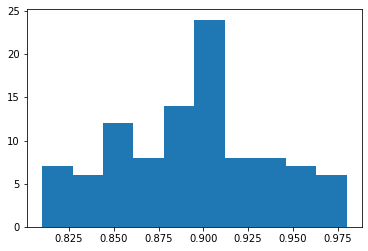

In [93]:
import numpy
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10)
print ( "average accuarcy is : ",numpy.array(results).mean())

## Task 1 (6 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

# First let us try to check the target class balance, maybe the high accuarcy is due to imbalanced data

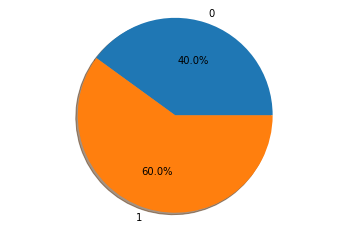

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
Y=pd.DataFrame(y)
labels =Y[0].astype('category').cat.categories.tolist()
counts = Y[0].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

# as we can see above if the model is biased to the majority class the highest accuarcy could be achieved is 60% , so the target label distribution is not the problem 

# Let us try the experiments without feature selection 

average accuarcy is :  0.4961


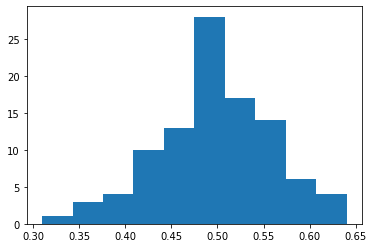

In [ ]:
import numpy 
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best =X

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
print ( "Average accuarcy is : ",numpy.array(results).mean())
plt.hist(results, bins=10);

# As we can see above, when we did the experiments without the feature selection step we obtained results near to our expectations, thus the problem is in the feature selection step 

# Let us do things in the right way :
# As we know the concept of cross validation depend on dividing the dataset  into k part, then the take one as a testing set and the ramaning k-1 as training , the training data is used to train the model and the testing is used to test the models quality and then it returns the average of qualities on all flods.
#in the above aproach we were selecting features depending on information from both training and testing covariance with the target and that is wrong, thus we should do that indepedently on test and train in each fold as we will see in our next analysis 

average accuarcy is :  0.5051


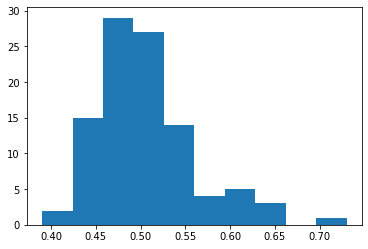

In [96]:
import numpy
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  #X_best = FeatureSelector(num_features_best).fit_transform(X, y)
  FS=FeatureSelector(num_features_best)

  # using pipeline for feature selection
  #model = LinearSVC()
  model = make_pipeline(FS, LinearSVC())

  # Estimating accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10)
print ( "average accuarcy is : ",numpy.array(results).mean())

In [94]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
#X_best = FeatureSelector(num_features_best).fit_transform(X, y)
FS=FeatureSelector(num_features_best)

# Simple classification model
#model = LinearSVC()

myModel = make_pipeline(FS, LinearSVC())

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(myModel, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")


CV score is 0.51
